In [67]:
from regvelovi import REGVELOVI

In [68]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

In [69]:
scv.set_figure_params()

In [830]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [840]:
adata.uns["skeleton"].sum().sum()

373.0

In [819]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [832]:
adata.uns["skeleton"].shape

(280, 280)

In [833]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [834]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=260)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 260 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [835]:
adata.layers["Ms"].max()

39747.324

In [836]:
adata.X = np.log1p(adata.X.copy())

In [837]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 87
num targets: 130


In [78]:
import torch
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [79]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T)

In [80]:
#GRN = torch.tensor(np.log1p(grnboost_m)) * torch.ones(W.T.shape) * torch.sign(corr_m)
#GRN = GRN.float()
#GRN

In [81]:
#coef = np.array(GRN).ravel()
#coef = coef[coef!=0]
#coef = np.abs(coef)
#coef = pd.DataFrame({"coef":coef})

In [82]:
#import seaborn as sns
#sns.displot(coef, x="coef", binwidth=0.1)

In [83]:
#coef = (coef - coef.min()) / (coef.max() - coef.min())
#sns.displot(coef, x="coef", binwidth=0.01)
#coef

In [84]:
#GRN[GRN!=0] = torch.sign(GRN[GRN!=0]) * torch.tensor(coef.iloc[:,0].values)
#reg_vae.module.v_encoder.grn.data = GRN
reg_vae.module.v_encoder.grn.data

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000, -0.0000],
        [-0.0537,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1076,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]])

In [85]:
reg_vae.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [86]:
reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [87]:
reg_vae.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [88]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.3215, 0.3100, 0.3579, 0.2337, 0.2787, 0.3628, 0.3426, 0.2759, 0.4508,
        0.3901, 0.4685, 0.4536, 0.4990, 0.4693, 0.2713, 0.4403, 0.3902, 0.2787,
        0.4016, 0.3867, 0.2705, 0.3614, 0.3991, 0.4474, 0.3799, 0.5078, 0.3523,
        0.4113, 0.4586, 0.4373, 0.4071, 0.4013, 0.3116, 0.4225, 0.3958, 0.4511,
        0.4245, 0.4034, 0.4865, 0.4185, 0.3649, 0.4787, 0.4063, 0.4329, 0.4524,
        0.4473, 0.4397, 0.3580, 0.3301, 0.4864, 0.3288, 0.3948, 0.3268, 0.4754,
        0.3931, 0.3852, 0.4927, 0.4320, 0.3845, 0.3423, 0.3859, 0.3484, 0.3812,
        0.3394, 0.4772, 0.4323, 0.2416, 0.2453, 0.1585, 0.4301, 0.5108, 0.4601,
        0.4162, 0.4156, 0.4469, 0.4072, 0.4872, 0.3340, 0.3503, 0.4384, 0.5017,
        0.3624, 0.4524, 0.4103, 0.4935, 0.3461, 0.3078, 0.4621, 0.4959, 0.4121,
        0.4006, 0.2810, 0.3505, 0.3031, 0.2208, 0.2678, 0.4658, 0.2877, 0.4652,
        0.3625, 0.3653, 0.3947, 0.4726, 0.4608, 0.4298, 0.3844, 0.4037, 0.4093,
        0.4717, 0.

In [89]:
reg_vae.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 158/500:  32%|███████████████▍                                 | 158/500 [02:06<04:34,  1.25it/s, loss=-371, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 3.031. Signaling Trainer to stop.


In [90]:
torch.abs(reg_vae.module.v_encoder.grn).sum()

tensor(100.5493, grad_fn=<SumBackward0>)

In [91]:
reg_vae.history['elbo_validation'].size

158

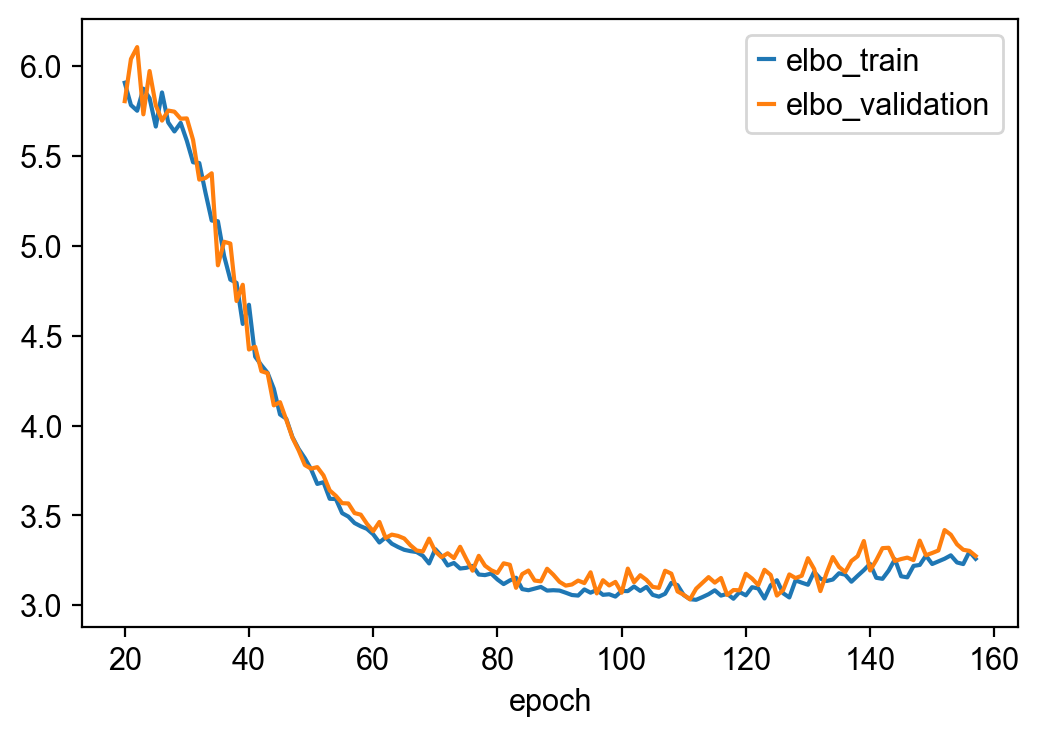

In [92]:
fig, ax = plt.subplots()
reg_vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_train")
reg_vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_validation")
plt.legend()

In [93]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(43.5779, grad_fn=<AddBackward0>)

In [269]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae)

In [270]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


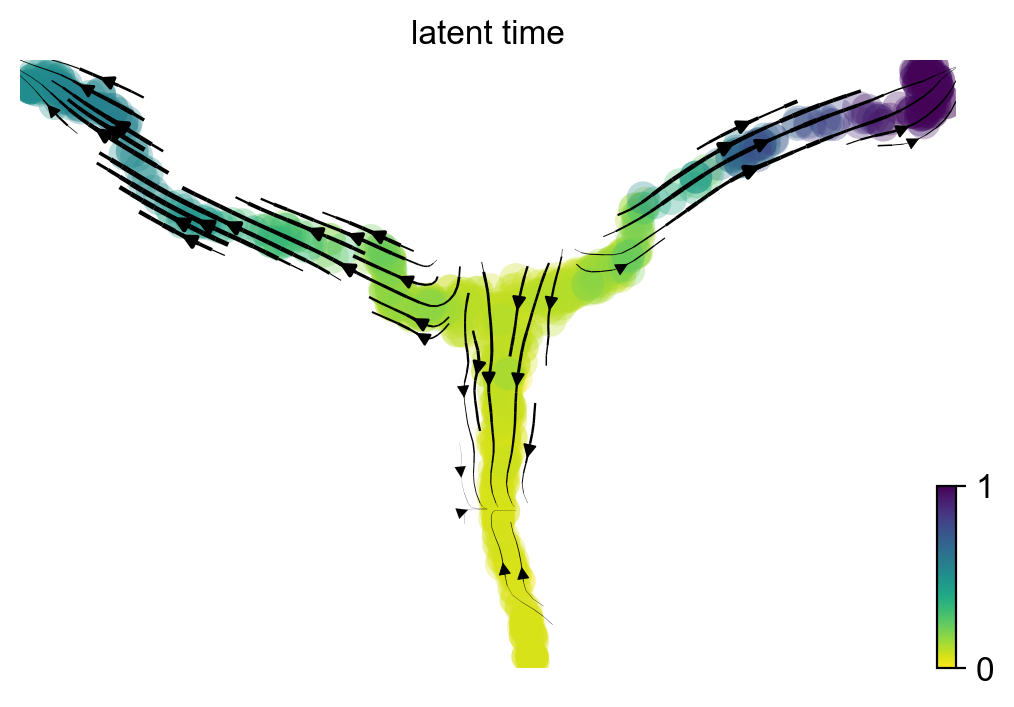

In [271]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [272]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.9078562709839605, pvalue=0.0)

In [273]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:117,117:(117*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [274]:
adata_target.layers["rna_velocity"].max()

17.252201555972604

In [275]:
corr.mean()

0.13481842279730558

In [276]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [277]:
GRN = W.T * reg_vae.module.v_encoder.grn

In [278]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [279]:
pre = GRN[W.T==1]

In [280]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [281]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [282]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

0.36705929143418536

In [283]:
velocity_regvelo_cor = velocity.copy()

## CellOracle Initilization

In [154]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae2 = REGVELOVI(adata,W=W.T)

In [155]:
celloracle_m = pd.read_csv("celloracle.csv",index_col = 0)
celloracle_m = np.array(celloracle_m)
celloracle_m.max()

29.10208104265729

In [156]:
GRN = torch.tensor(np.log1p(celloracle_m)) * W.T * torch.sign(reg_vae2.module.v_encoder.grn.data)
GRN = GRN.float()
GRN

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.1996,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.3880,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [157]:
reg_vae2.module.v_encoder.grn.data = GRN
reg_vae2.module.v_encoder.grn

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.1996,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.3880,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [158]:
reg_vae2.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [159]:
reg_vae2.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [160]:
reg_vae2.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [161]:
reg_vae2.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.3215, 0.3100, 0.3579, 0.2337, 0.2787, 0.3628, 0.3426, 0.2759, 0.4508,
        0.3901, 0.4685, 0.4536, 0.4990, 0.4693, 0.2713, 0.4403, 0.3902, 0.2787,
        0.4016, 0.3867, 0.2705, 0.3614, 0.3991, 0.4474, 0.3799, 0.5078, 0.3523,
        0.4113, 0.4586, 0.4373, 0.4071, 0.4013, 0.3116, 0.4225, 0.3958, 0.4511,
        0.4245, 0.4034, 0.4865, 0.4185, 0.3649, 0.4787, 0.4063, 0.4329, 0.4524,
        0.4473, 0.4397, 0.3580, 0.3301, 0.4864, 0.3288, 0.3948, 0.3268, 0.4754,
        0.3931, 0.3852, 0.4927, 0.4320, 0.3845, 0.3423, 0.3859, 0.3484, 0.3812,
        0.3394, 0.4772, 0.4323, 0.2416, 0.2453, 0.1585, 0.4301, 0.5108, 0.4601,
        0.4162, 0.4156, 0.4469, 0.4072, 0.4872, 0.3340, 0.3503, 0.4384, 0.5017,
        0.3624, 0.4524, 0.4103, 0.4935, 0.3461, 0.3078, 0.4621, 0.4959, 0.4121,
        0.4006, 0.2810, 0.3505, 0.3031, 0.2208, 0.2678, 0.4658, 0.2877, 0.4652,
        0.3625, 0.3653, 0.3947, 0.4726, 0.4608, 0.4298, 0.3844, 0.4037, 0.4093,
        0.4717, 0.

In [162]:
reg_vae2.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 181/500:  36%|█████████████████▋                               | 181/500 [02:41<04:44,  1.12it/s, loss=-295, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.899. Signaling Trainer to stop.


In [163]:
torch.abs(reg_vae2.module.v_encoder.grn).sum()

tensor(573.3176, grad_fn=<SumBackward0>)

In [164]:
reg_vae2.history['elbo_validation'].size

181

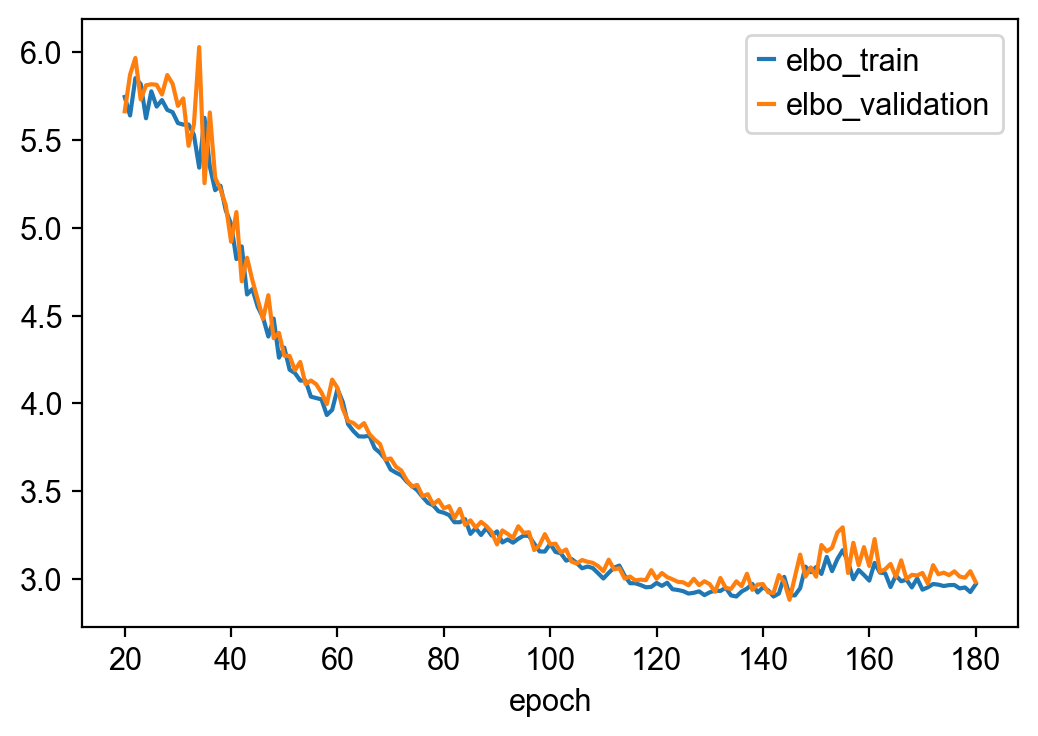

In [165]:
fig, ax = plt.subplots()
reg_vae2.history["elbo_train"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_train")
reg_vae2.history["elbo_validation"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_validation")
plt.legend()

In [166]:
sum(p.pow(2.0).sum() for p in reg_vae2.module.v_encoder.grn)

tensor(1154.6643, grad_fn=<AddBackward0>)

In [284]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae2)

In [285]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


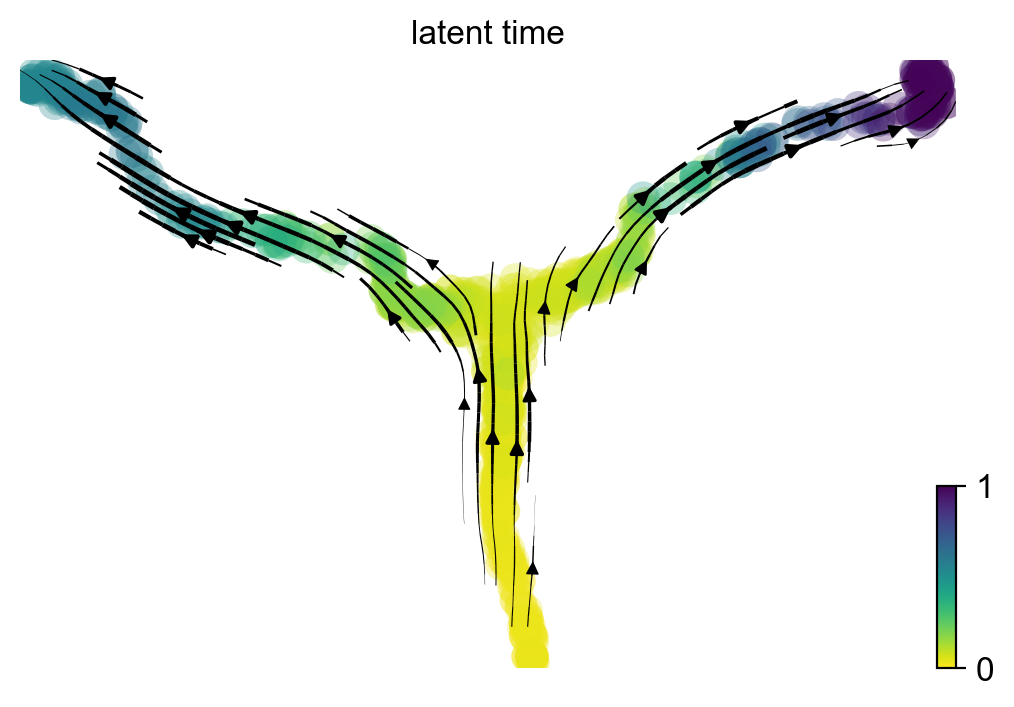

In [286]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [287]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.9175818370605282, pvalue=0.0)

In [288]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:117,117:(117*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [289]:
adata_target.layers["rna_velocity"].max()

17.252201555972604

In [290]:
corr.mean()

0.14360528289102573

In [291]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [292]:
GRN = W.T * reg_vae2.module.v_encoder.grn

In [293]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [294]:
pre = GRN[W.T==1]

In [295]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [296]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [297]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

0.6231346771432961

In [298]:
velocity_regvelo_celloracle = velocity.copy()

In [181]:
import pandas as pd
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

In [182]:
GEP = pd.DataFrame(adata.X.todense(),columns = adata.var.index.values)

In [183]:
network = grnboost2(expression_data=GEP,
                    tf_names=adata.uns["regulators"].tolist())

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [184]:
ind = [i in adata.uns["targets"] for i in network["target"]]

In [185]:
network = network[ind]

In [186]:
grnboost_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
grnboost_m = pd.DataFrame(grnboost_m,index = adata.uns["targets"].tolist(), columns = adata.uns["regulators"].tolist())

In [187]:
for i in adata.uns["targets"]:
    for j in adata.uns["regulators"]:
        ind = (network["TF"] == j) & (network["target"] == i)
        if sum(ind) > 0:
            pdd = network[ind]
            grnboost_m.loc[i,j] = pdd["importance"].values

In [188]:
grnboost_m = np.array(grnboost_m)

In [189]:
grnboost_m.shape

(117, 73)

In [190]:
grn_boost_pre = grnboost_m[np.array(adata.uns["skeleton"]).T==1]

In [191]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"]).T==1]

In [192]:
corr, _ = stats.spearmanr(abs(grn_boost_pre),abs(gt))
corr

0.47167790903384843

In [193]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae3 = REGVELOVI(adata,W=W.T)

In [195]:
GRN = torch.tensor(np.log1p(grnboost_m)) * W.T * torch.sign(reg_vae3.module.v_encoder.grn.data)
GRN = GRN.float()
GRN

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.2227,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.3959,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [196]:
reg_vae3.module.v_encoder.grn.data = GRN
reg_vae3.module.v_encoder.grn

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.2227,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.3959,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [197]:
reg_vae3.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [198]:
reg_vae3.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [199]:
reg_vae3.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [200]:
reg_vae3.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.3215, 0.3100, 0.3579, 0.2337, 0.2787, 0.3628, 0.3426, 0.2759, 0.4508,
        0.3901, 0.4685, 0.4536, 0.4990, 0.4693, 0.2713, 0.4403, 0.3902, 0.2787,
        0.4016, 0.3867, 0.2705, 0.3614, 0.3991, 0.4474, 0.3799, 0.5078, 0.3523,
        0.4113, 0.4586, 0.4373, 0.4071, 0.4013, 0.3116, 0.4225, 0.3958, 0.4511,
        0.4245, 0.4034, 0.4865, 0.4185, 0.3649, 0.4787, 0.4063, 0.4329, 0.4524,
        0.4473, 0.4397, 0.3580, 0.3301, 0.4864, 0.3288, 0.3948, 0.3268, 0.4754,
        0.3931, 0.3852, 0.4927, 0.4320, 0.3845, 0.3423, 0.3859, 0.3484, 0.3812,
        0.3394, 0.4772, 0.4323, 0.2416, 0.2453, 0.1585, 0.4301, 0.5108, 0.4601,
        0.4162, 0.4156, 0.4469, 0.4072, 0.4872, 0.3340, 0.3503, 0.4384, 0.5017,
        0.3624, 0.4524, 0.4103, 0.4935, 0.3461, 0.3078, 0.4621, 0.4959, 0.4121,
        0.4006, 0.2810, 0.3505, 0.3031, 0.2208, 0.2678, 0.4658, 0.2877, 0.4652,
        0.3625, 0.3653, 0.3947, 0.4726, 0.4608, 0.4298, 0.3844, 0.4037, 0.4093,
        0.4717, 0.

In [201]:
reg_vae3.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 214/500:  43%|████████████████████▉                            | 214/500 [03:08<04:12,  1.13it/s, loss=-318, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.272. Signaling Trainer to stop.


In [202]:
torch.abs(reg_vae3.module.v_encoder.grn).sum()

tensor(504.6790, grad_fn=<SumBackward0>)

In [203]:
reg_vae3.history['elbo_validation'].size

214

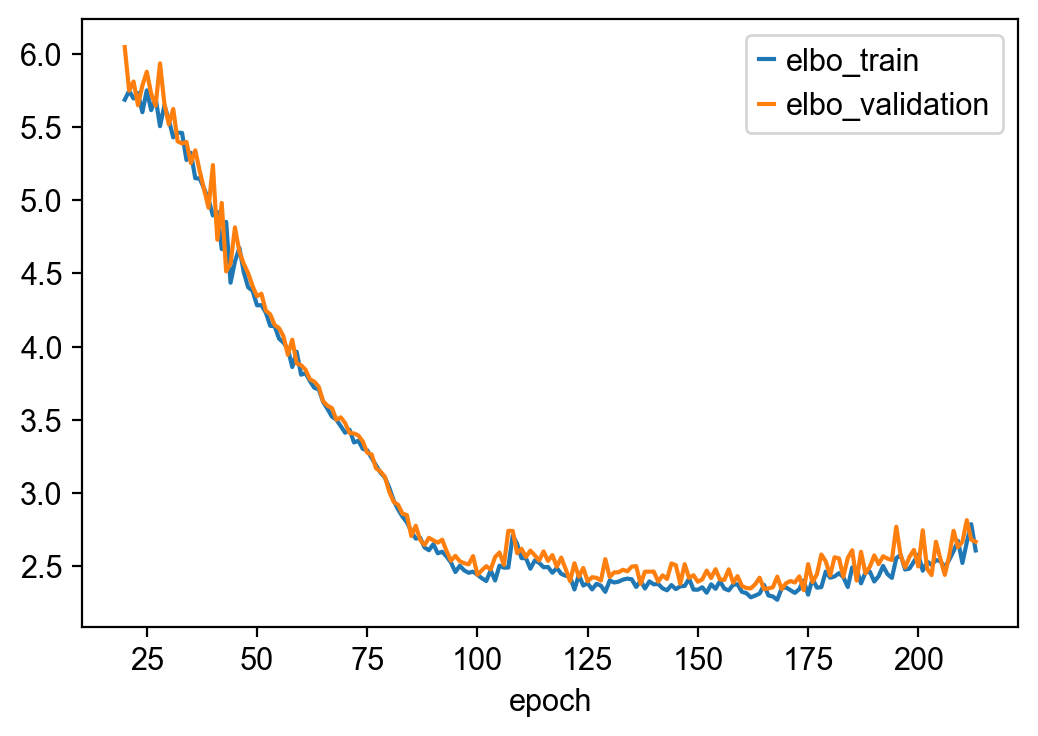

In [204]:
fig, ax = plt.subplots()
reg_vae3.history["elbo_train"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_train")
reg_vae3.history["elbo_validation"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_validation")
plt.legend()

In [205]:
sum(p.pow(2.0).sum() for p in reg_vae3.module.v_encoder.grn)

tensor(1131.9014, grad_fn=<AddBackward0>)

In [299]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae3)

In [300]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


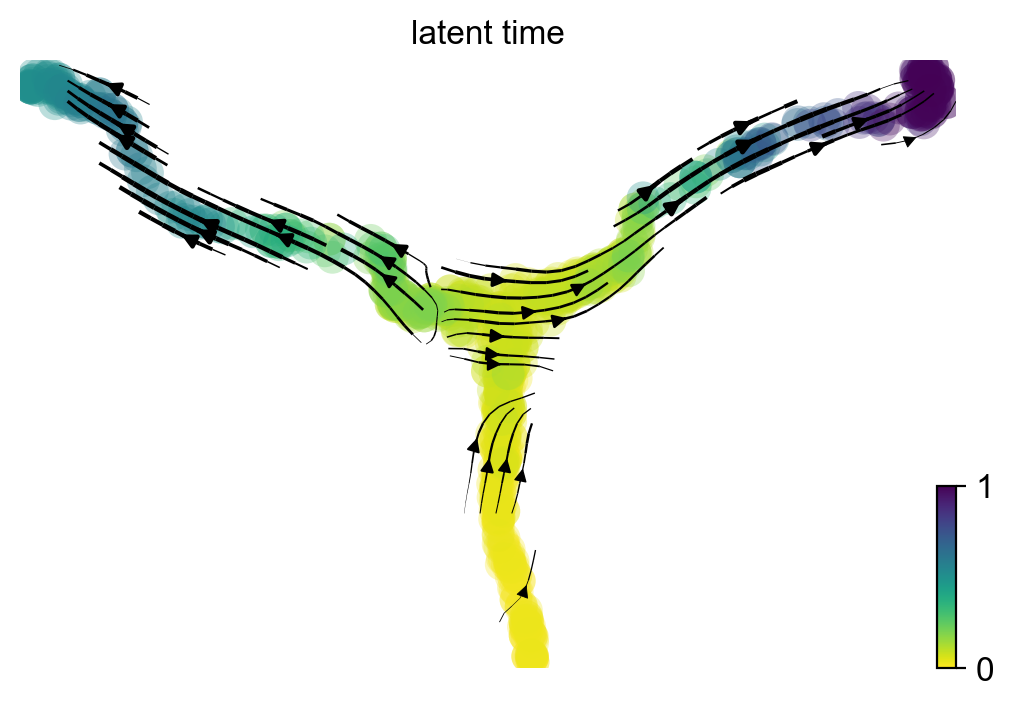

In [301]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [302]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.9205506374197064, pvalue=0.0)

In [303]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:117,117:(117*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [304]:
adata_target.layers["rna_velocity"].max()

17.252201555972604

In [305]:
corr.mean()

0.13688349916243803

In [306]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [307]:
GRN = W.T * reg_vae3.module.v_encoder.grn

In [308]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [309]:
pre = GRN[W.T==1]

In [310]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [311]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [312]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

0.6024712599782394

In [313]:
velocity_regvelo_grnboost2 = velocity.copy()

In [410]:
from velovi import preprocess_data, VELOVI
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 484/500:  97%|███████████████████████████████████████████████▍ | 484/500 [01:11<00:02,  6.80it/s, loss=-464, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -451.551. Signaling Trainer to stop.


In [411]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    

add_velovi_outputs_to_adata(adata, vae)

In [412]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


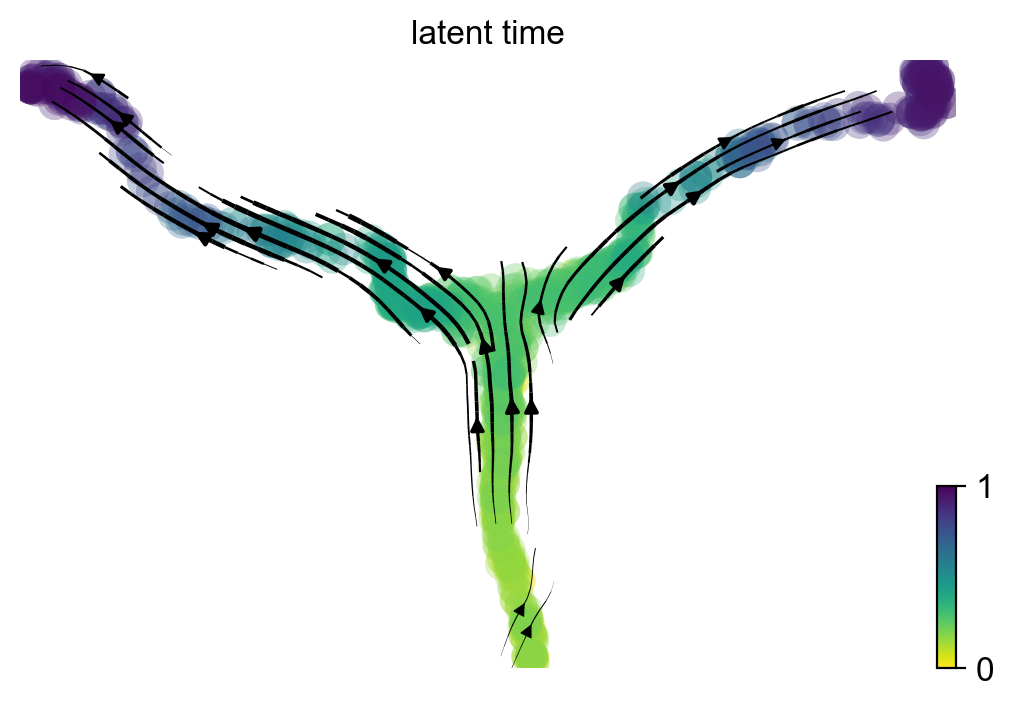

In [413]:
scv.tl.latent_time(adata,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'latent_time')

In [414]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [415]:
corr.mean()

0.10919353139736739

In [416]:
import scipy
scipy.stats.spearmanr(adata.obs["latent_time"], adata.obs["sim_time"])

SignificanceResult(statistic=0.9075302190139001, pvalue=0.0)

In [417]:
velocity_velovi = velocity.copy()

## Using the cellrank to predict terminal state

In [730]:
adata = sc.read_h5ad("dataset_branch_v4.h5ad")
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.leiden(adata)
cluster = adata.obs["leiden"].copy()

adata = sc.read_h5ad("dataset_branch_v4.h5ad")
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.X = np.log1p(adata.X.copy())
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.obs["leiden"] = cluster.copy()

Filtered out 29 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Filtered out 29 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 73
num targets: 117


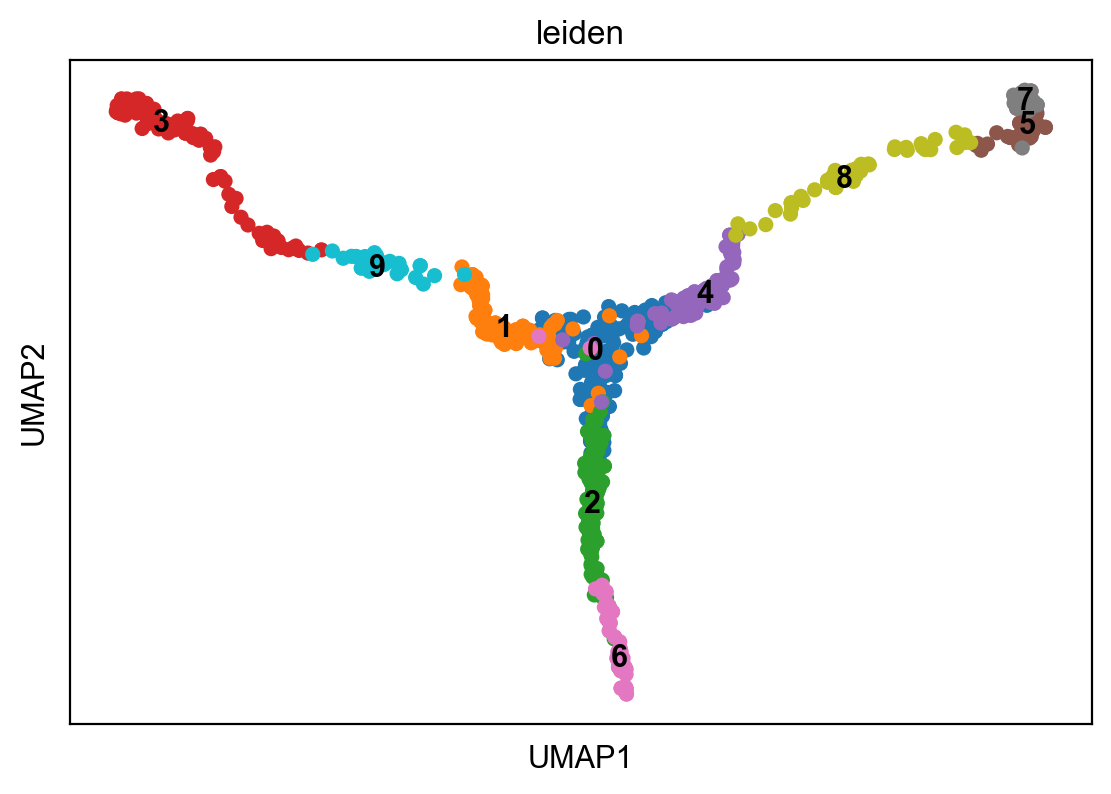

In [731]:
adata.obsm["X_umap"] = adata.obsm["dimred"][:,:2].copy()
sc.pl.scatter(adata, color=['leiden'],basis="umap",legend_loc='on data')

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


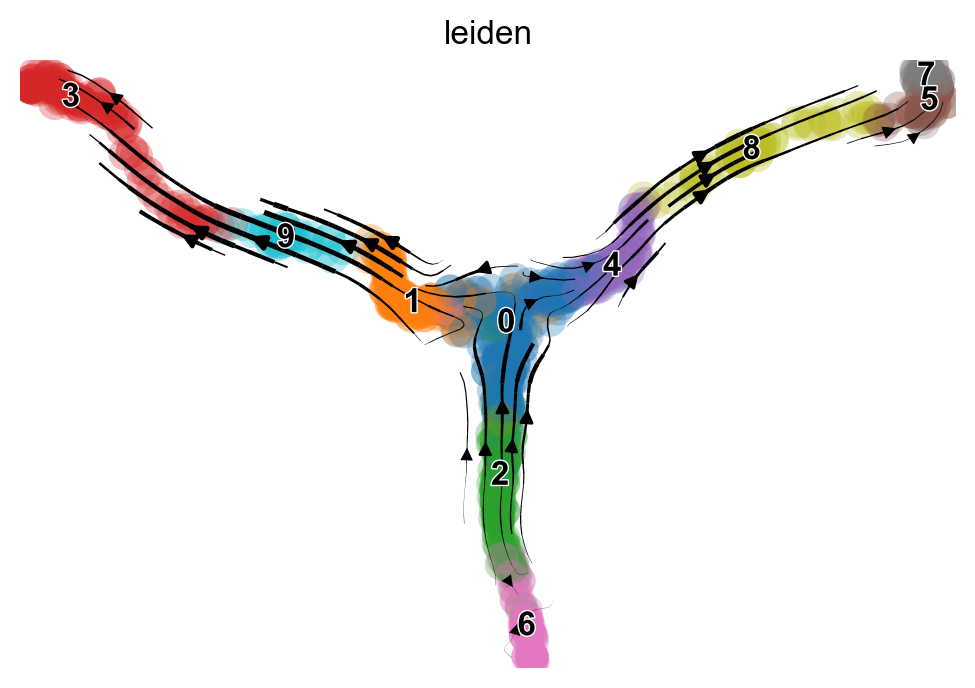

In [732]:
adata.layers["velocity"] = np.array(adata.layers["rna_velocity"].todense().copy())
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'leiden')

In [733]:
### running cellrank
import cellrank as cr

In [734]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [735]:
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

In [736]:
combined_kernel = vk

In [737]:
g = cr.estimators.GPCCA(combined_kernel)

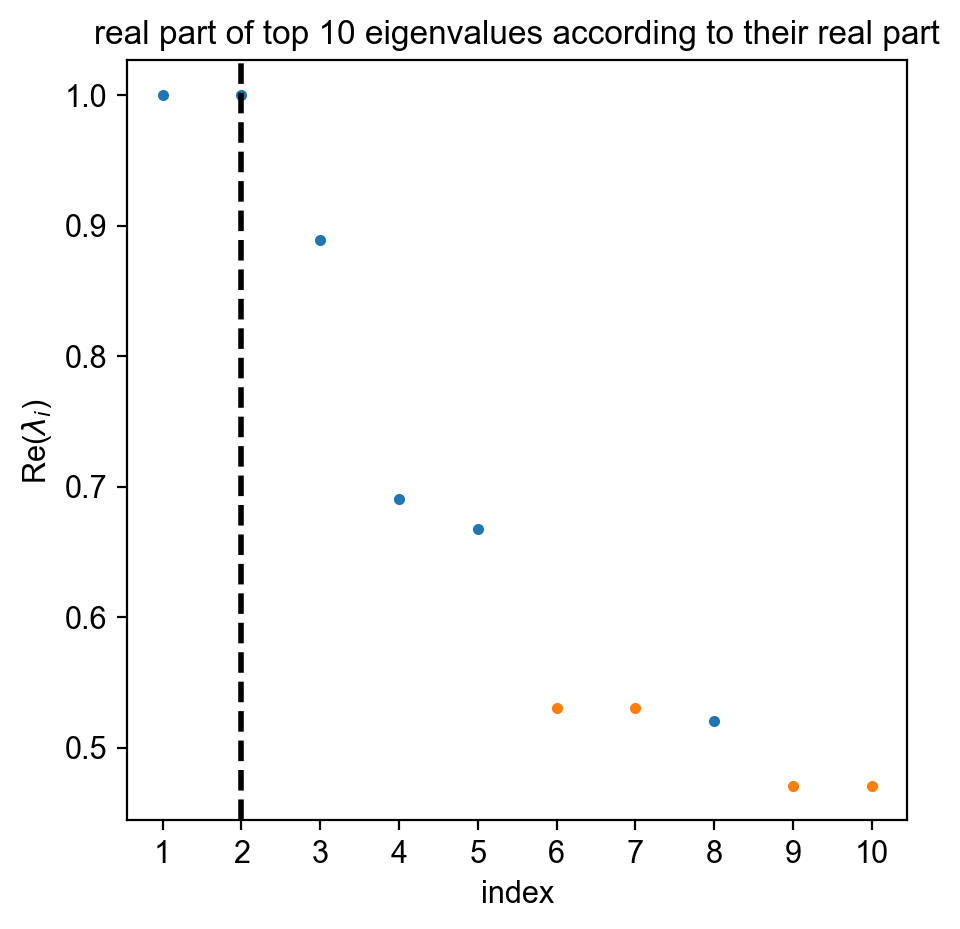

In [738]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [739]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "5"])

Using pre-computed Schur decomposition


In [740]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [741]:
### calculate groundtruth cellfate
cellfate = pd.DataFrame(g.absorption_probabilities)

In [742]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_5"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

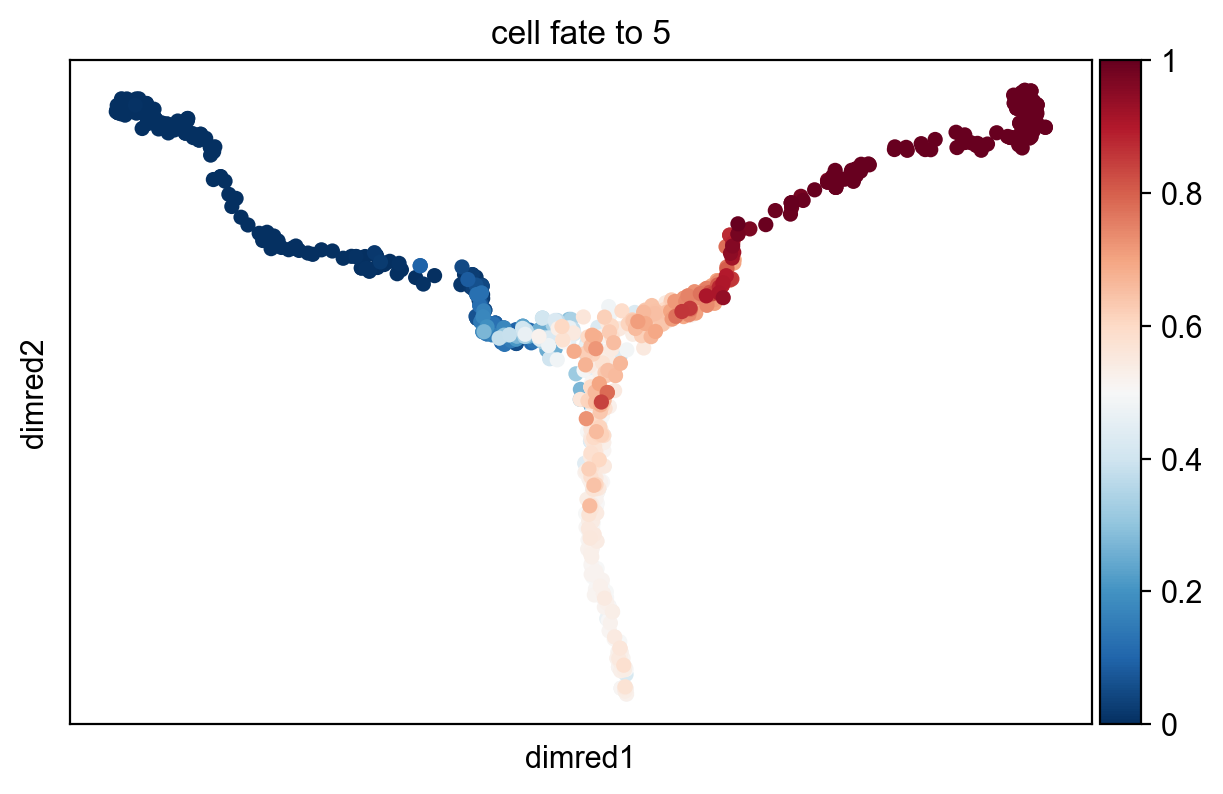

In [743]:
sc.pl.scatter(adata, color=['cell_fate_to_5'],basis="dimred")

In [744]:
g.compute_terminal_states(method="eigengap")

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


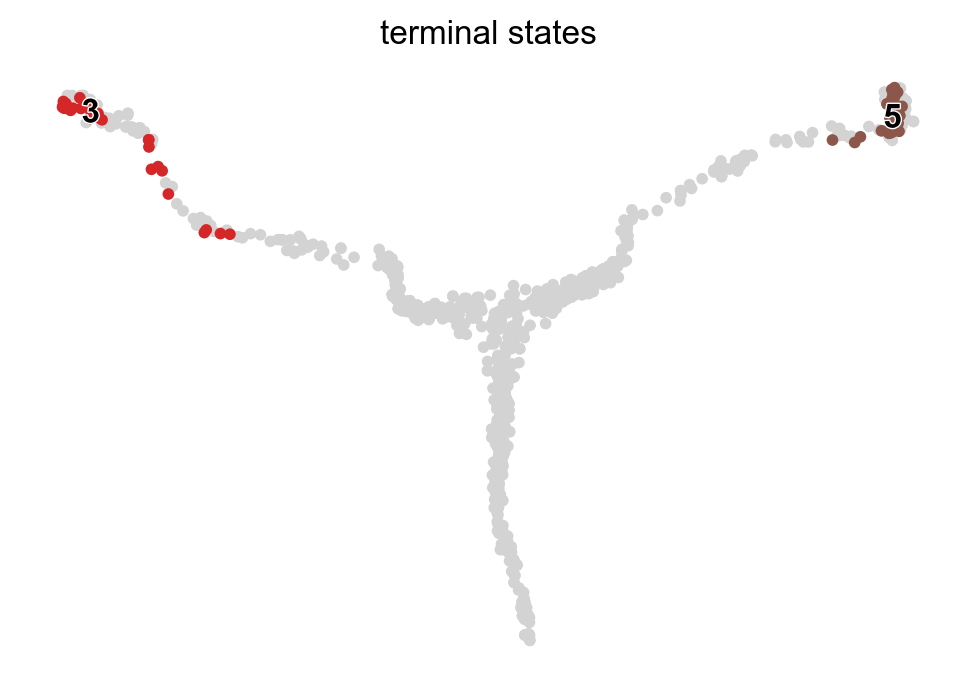

In [746]:
g.plot_terminal_states(same_plot=True)

In [664]:
### Using VeloVI to compute velocity
cluster = adata.obs["leiden"].copy()

In [747]:
indices = adata_target.var.index.copy()
adata = sc.read_h5ad("dataset_branch_v4.h5ad")
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.X = np.log1p(adata.X.copy())
adata = adata[:,indices].copy()
adata = preprocess_data(adata,filter_on_r2=False)
#adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

Filtered out 29 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [748]:
adata.obs["leiden"] = cluster.copy()
adata.obsm["X_umap"] = adata.obsm["dimred"][:,:2].copy()

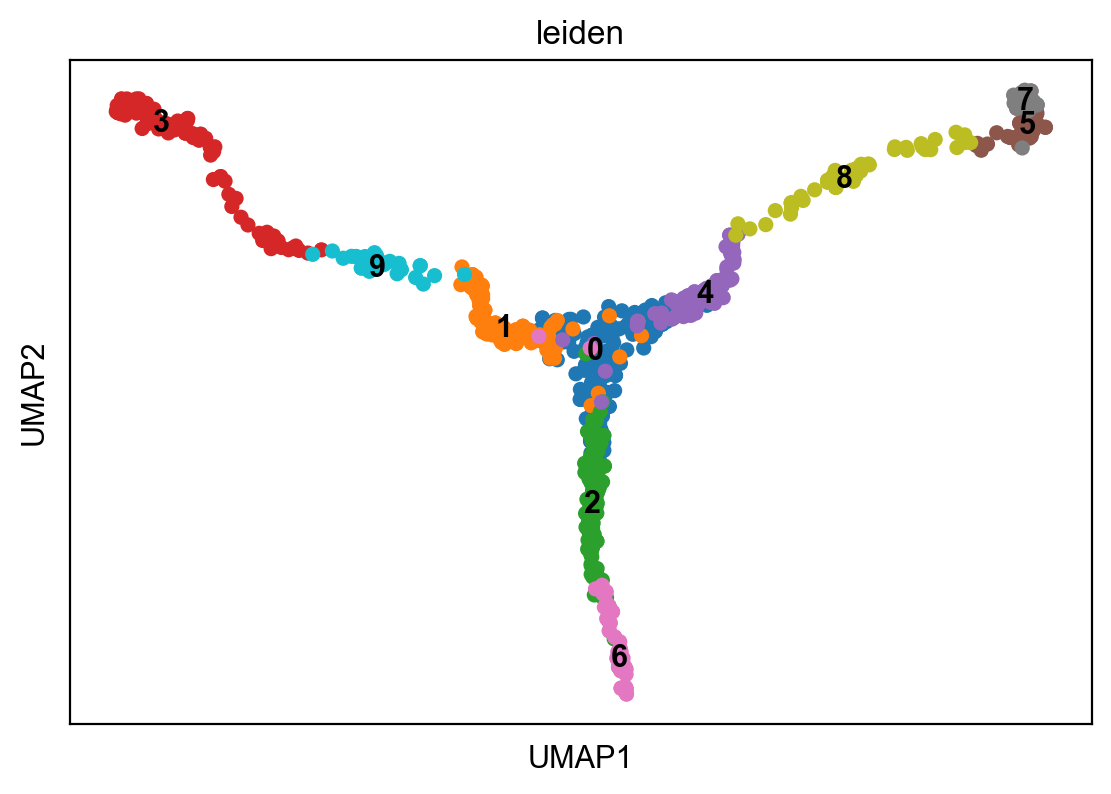

In [749]:
sc.pl.scatter(adata, color=['leiden'],basis="umap",legend_loc='on data')

In [750]:
adata.layers["velocity"] = velocity_regvelo_cor.copy()
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [751]:
combined_kernel = vk

In [752]:
g = cr.estimators.GPCCA(combined_kernel)

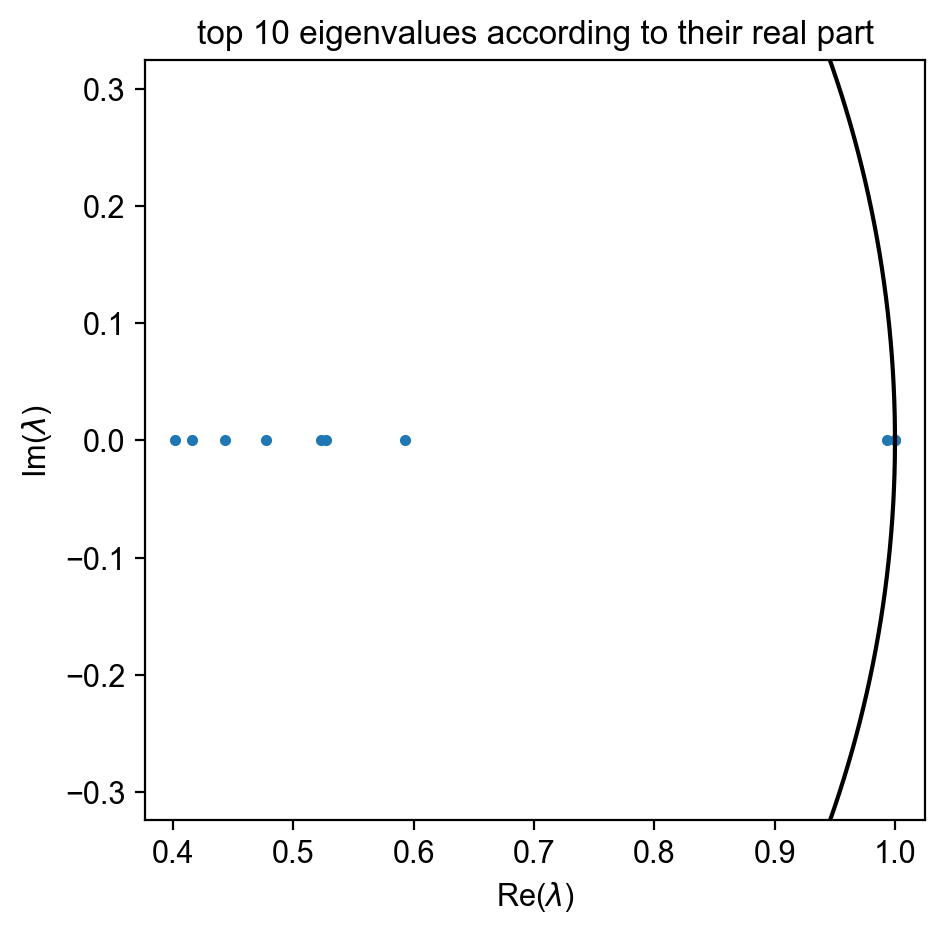

In [753]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [754]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "7"])

Using pre-computed Schur decomposition


In [755]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [756]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [757]:
cellfate_velovi

,0,1
0,2.026022e-09,1.000000
1,9.772550e-01,0.022745
2,5.050372e-01,0.494963
3,5.080695e-01,0.491930
4,5.072513e-01,0.492748
...,...,...
995,5.095020e-01,0.490498
996,1.943547e-01,0.805645
997,4.991979e-01,0.500802
998,5.940164e-01,0.405983


In [758]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_7"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

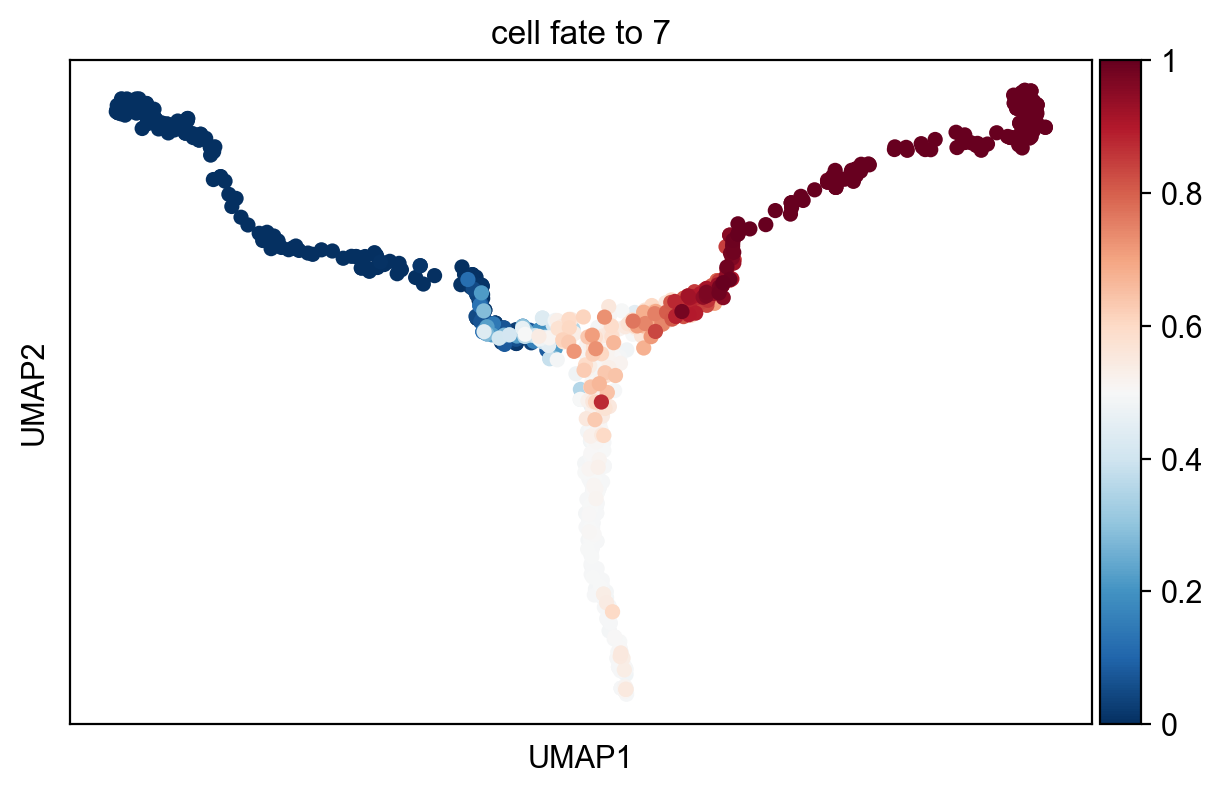

In [759]:
sc.pl.scatter(adata, color=['cell_fate_to_7'],basis="umap")

In [760]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 7): "+str(corr2))
corr_velovi = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9627516155737595
corr to cell fate (cluster 7): 0.9623558158285215


In [761]:
g.compute_terminal_states(method="eigengap")

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


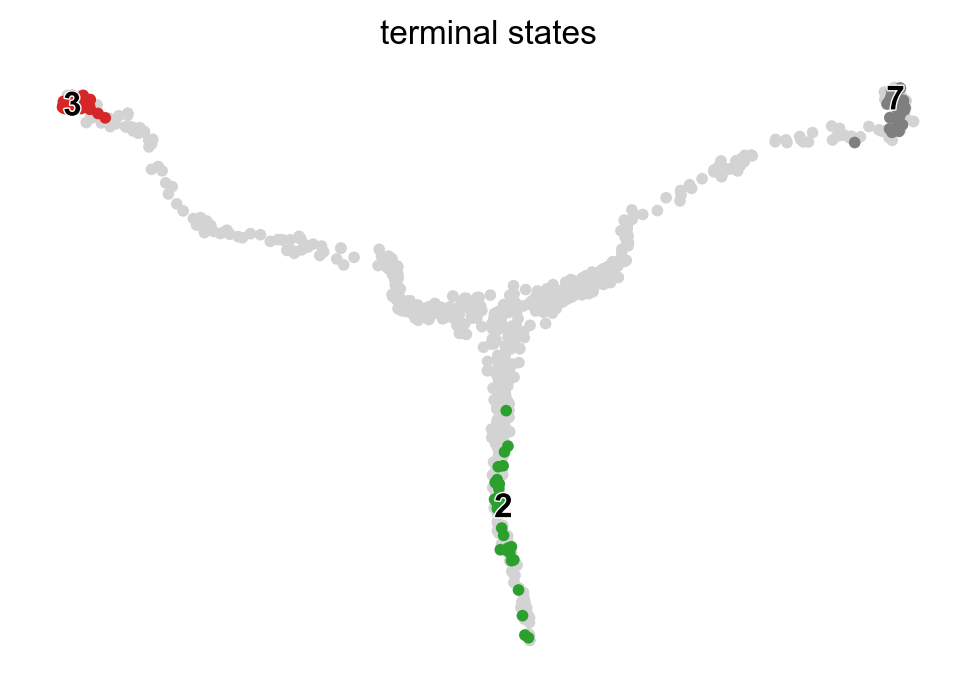

In [762]:
g.plot_terminal_states(same_plot=True)

## Use Regvelo (Correlation Initialization)

In [763]:
adata.layers["velocity"] = velocity_regvelo_celloracle.copy()
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [764]:
combined_kernel = vk

In [765]:
g = cr.estimators.GPCCA(combined_kernel)

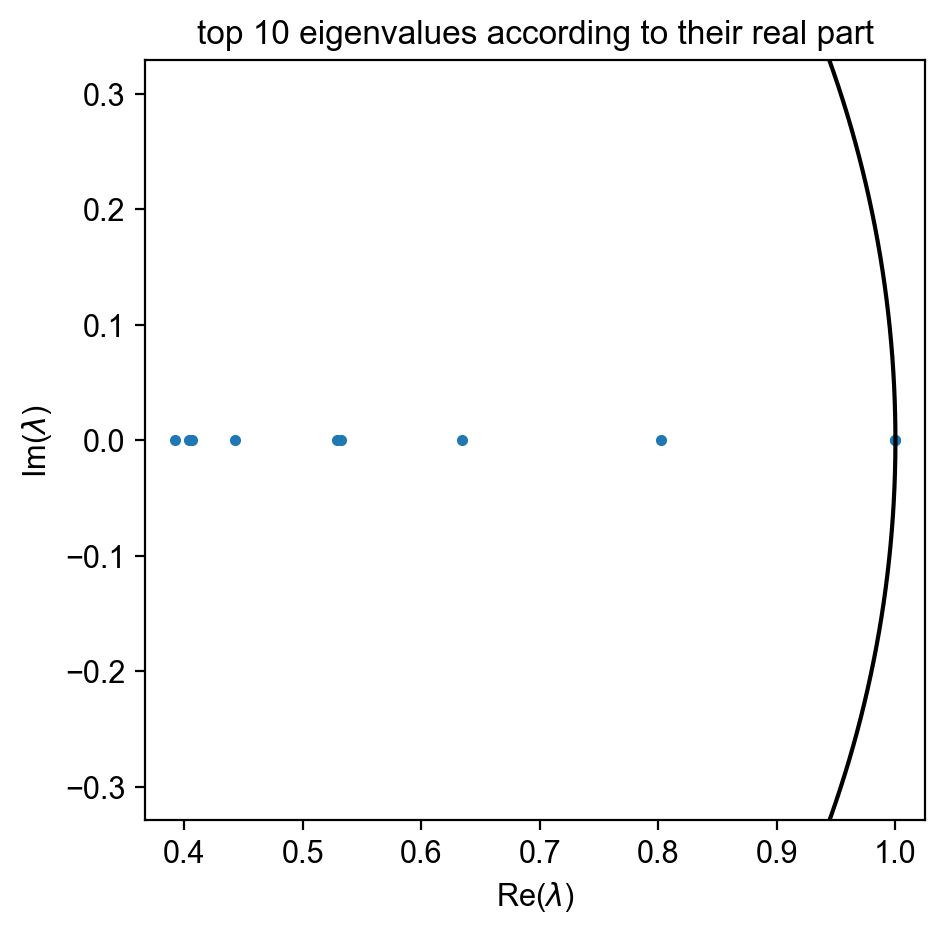

In [766]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [767]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "5"])

Using pre-computed Schur decomposition


In [768]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [769]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [770]:
cellfate_velovi

,0,1
0,1.759961e-08,1.000000
1,9.610924e-01,0.038908
2,4.006575e-01,0.599343
3,4.725021e-01,0.527498
4,4.404894e-01,0.559511
...,...,...
995,4.797916e-01,0.520208
996,1.468593e-01,0.853141
997,3.491703e-01,0.650830
998,6.949649e-01,0.305035


In [771]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_7"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

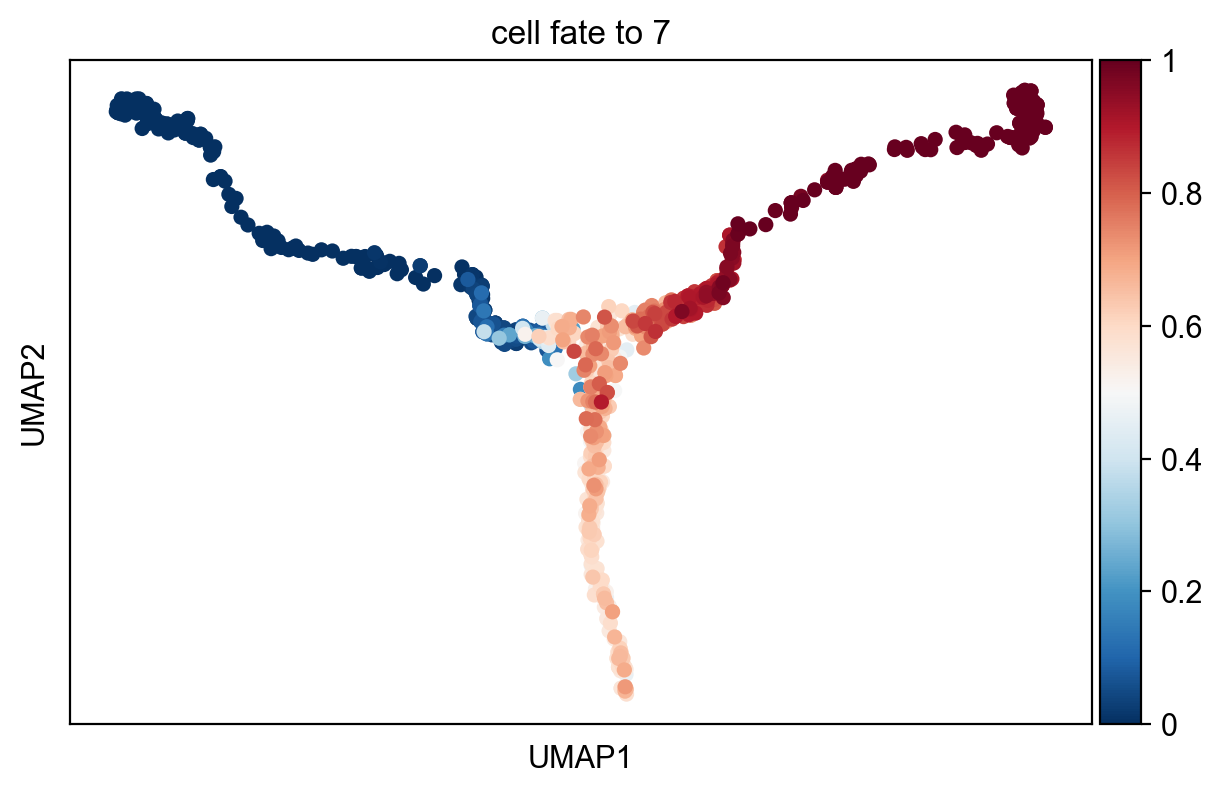

In [772]:
sc.pl.scatter(adata, color=['cell_fate_to_7'],basis="umap")

In [773]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 7): "+str(corr2))
corr_velovi = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9710093022510656
corr to cell fate (cluster 7): 0.9709868670184739


In [774]:
g.compute_terminal_states(method="eigengap")

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


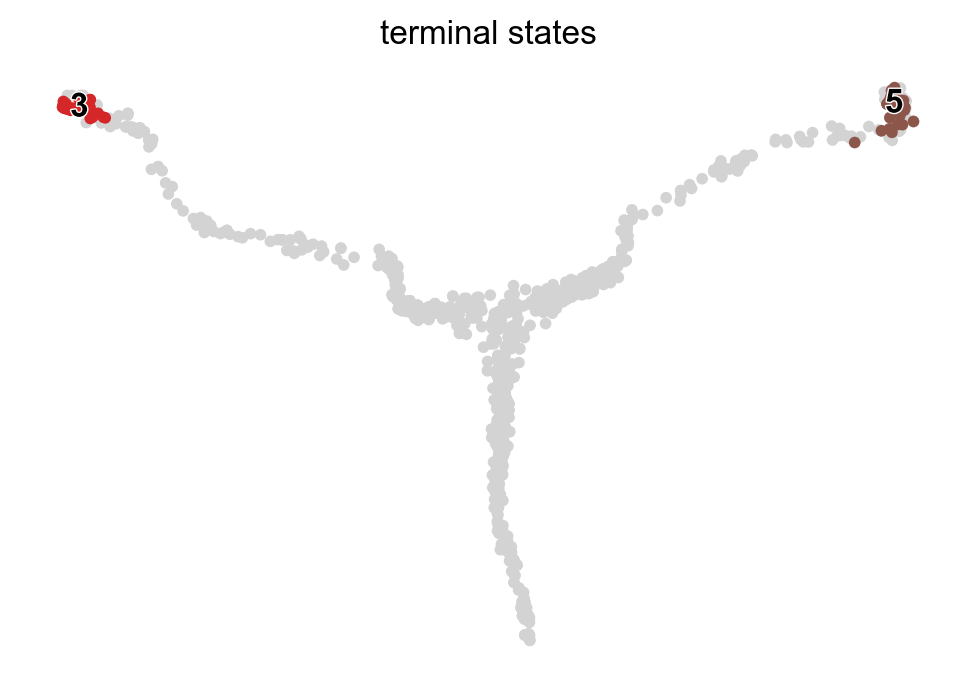

In [775]:
g.plot_terminal_states(same_plot=True)

In [776]:
adata.layers["velocity"] = velocity_regvelo_grnboost2.copy()
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [777]:
combined_kernel = vk

In [778]:
g = cr.estimators.GPCCA(combined_kernel)

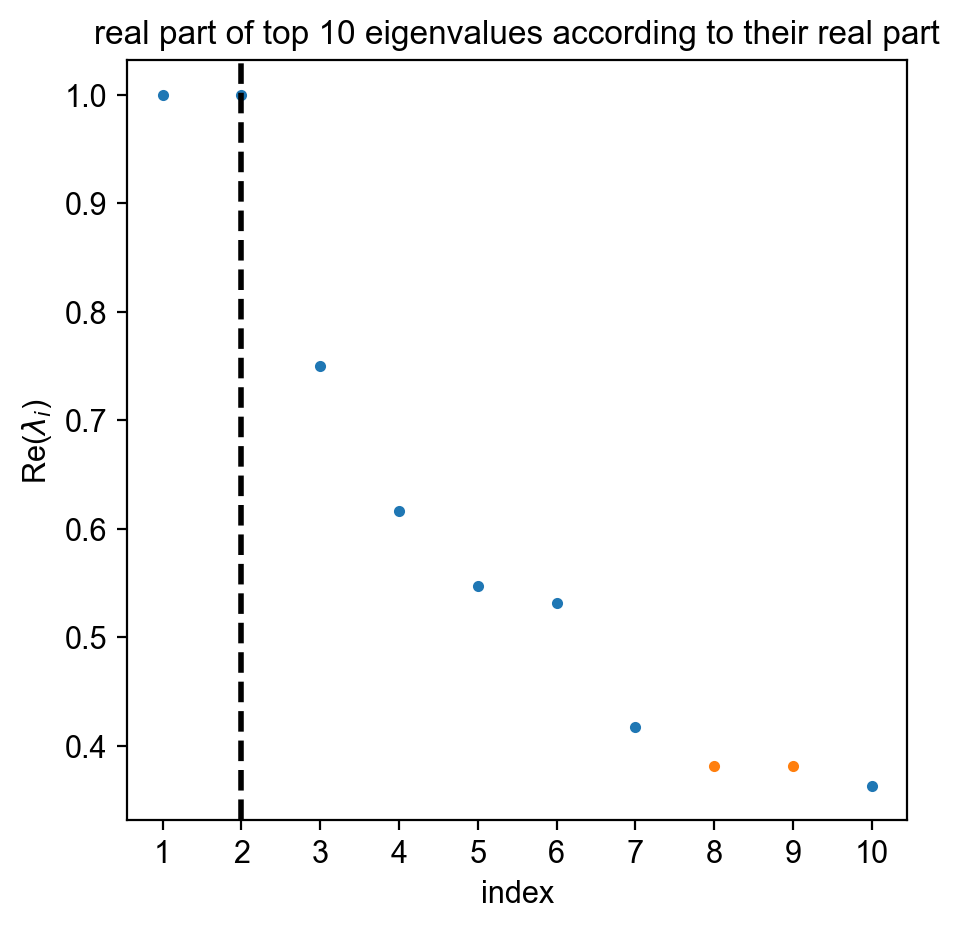

In [779]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [780]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "5"])

Using pre-computed Schur decomposition


In [781]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [782]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [783]:
cellfate_velovi

,0,1
0,2.655860e-10,1.000000
1,9.314007e-01,0.068599
2,4.377122e-02,0.956229
3,5.658028e-02,0.943420
4,5.001964e-02,0.949980
...,...,...
995,6.468214e-02,0.935318
996,6.773707e-03,0.993226
997,4.037905e-02,0.959621
998,1.150560e-01,0.884944


In [784]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_7"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

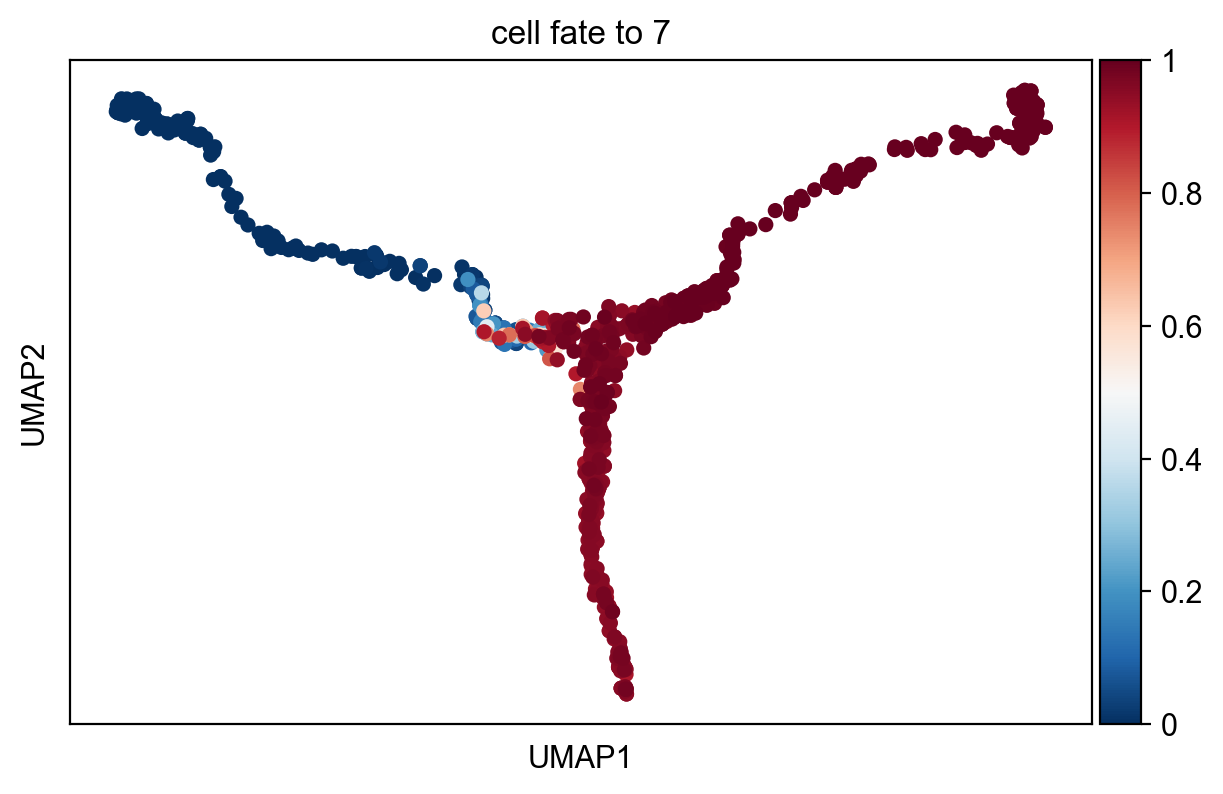

In [785]:
sc.pl.scatter(adata, color=['cell_fate_to_7'],basis="umap")

In [786]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 7): "+str(corr2))
corr_velovi = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9659485132113158
corr to cell fate (cluster 7): 0.9650254764996787


In [787]:
g.compute_terminal_states(method="eigengap")

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


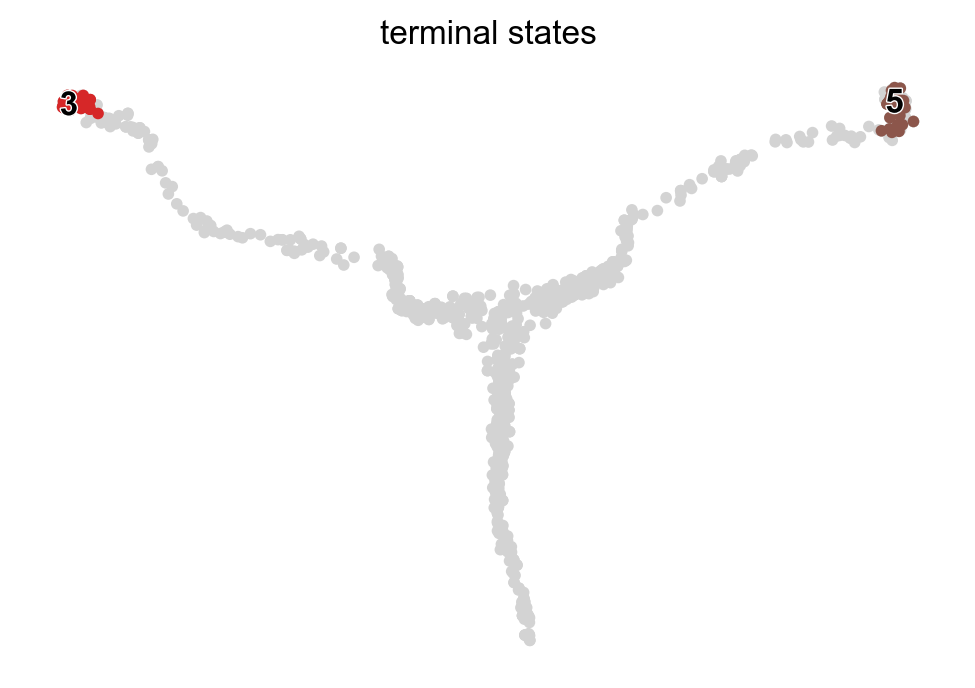

In [788]:
g.plot_terminal_states(same_plot=True)

In [789]:
### Using VeloVI to compute velocity
cluster = adata.obs["leiden"].copy()

In [790]:
indices = adata_target.var.index.copy()
adata = sc.read_h5ad("dataset_branch_v4.h5ad")
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.X = np.log1p(adata.X.copy())
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

Filtered out 29 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 73
num targets: 117


In [791]:
adata.obs["leiden"] = cluster.copy()
adata.obsm["X_umap"] = adata.obsm["dimred"][:,:2].copy()

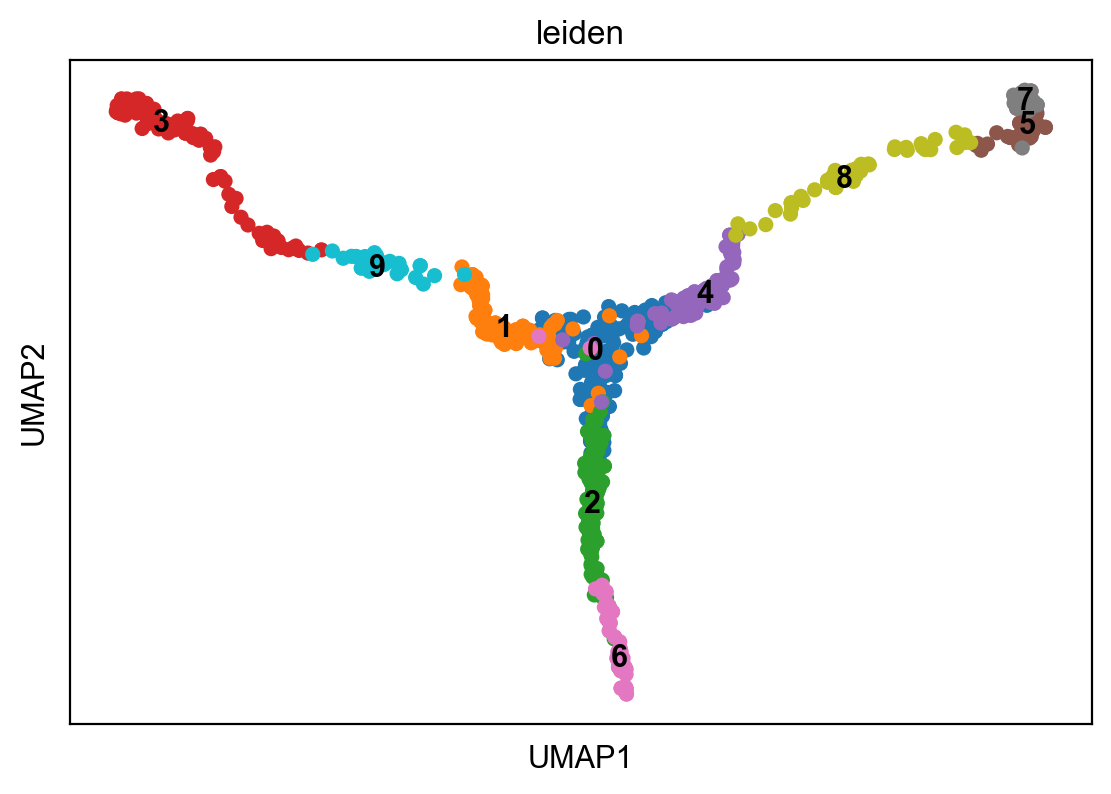

In [792]:
sc.pl.scatter(adata, color=['leiden'],basis="umap",legend_loc='on data')

In [793]:
adata.layers["velocity"] = velocity_velovi.copy()
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/1000 [00:00<?, ?cell/s]

  0%|          | 0/1000 [00:00<?, ?cell/s]

VelocityKernel

In [794]:
combined_kernel = vk

In [795]:
g = cr.estimators.GPCCA(combined_kernel)

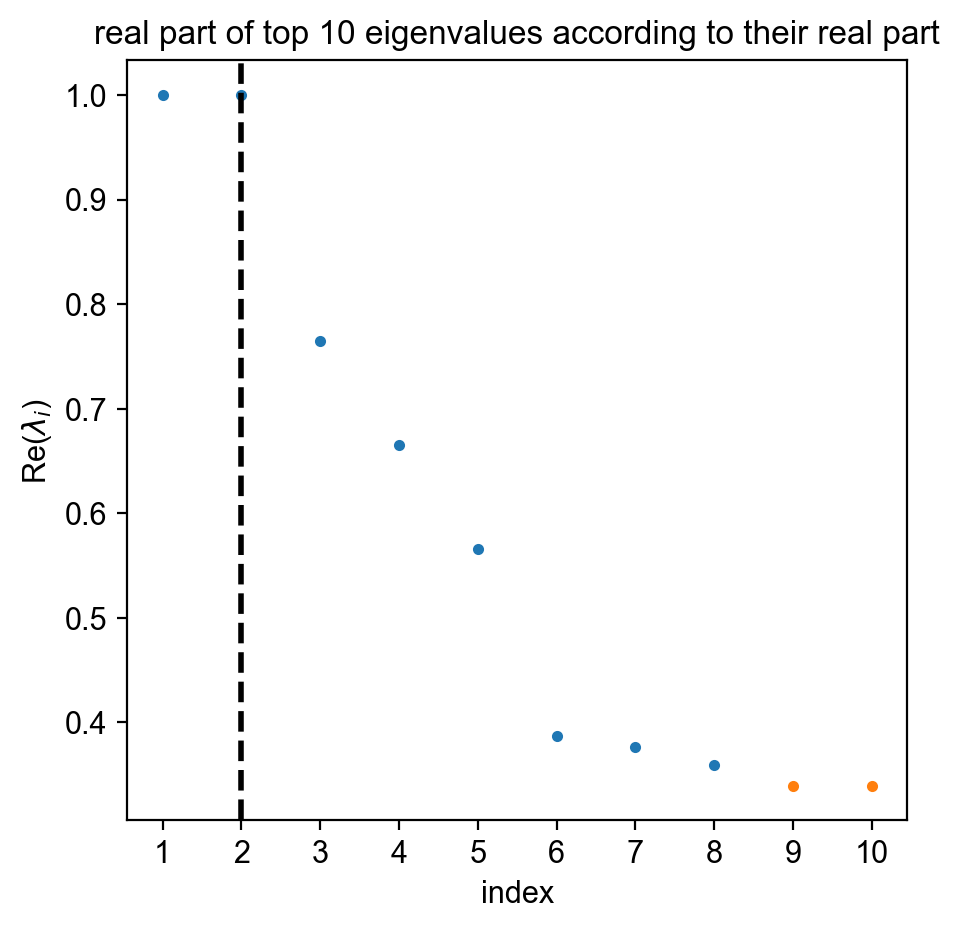

In [796]:
g.compute_schur(n_components=10,method='brandts')
g.plot_spectrum()

In [797]:
g.compute_macrostates(cluster_key="leiden")
g.set_terminal_states_from_macrostates(["3", "5"])

Using pre-computed Schur decomposition


In [798]:
g.compute_absorption_probabilities()

  0%|          | 0/2 [00:00<?, ?/s]

In [799]:
cellfate_velovi = pd.DataFrame(g.absorption_probabilities)

In [800]:
cellfate_velovi

,0,1
0,0.000022,0.999978
1,0.957934,0.042066
2,0.346457,0.653542
3,0.547813,0.452187
4,0.483224,0.516775
...,...,...
995,0.485598,0.514401
996,0.116459,0.883541
997,0.190751,0.809248
998,0.830994,0.169006


In [801]:
adata.obs["cell_fate_to_3"] = pd.DataFrame(g.absorption_probabilities).iloc[:,0].values
adata.obs["cell_fate_to_7"] = pd.DataFrame(g.absorption_probabilities).iloc[:,1].values

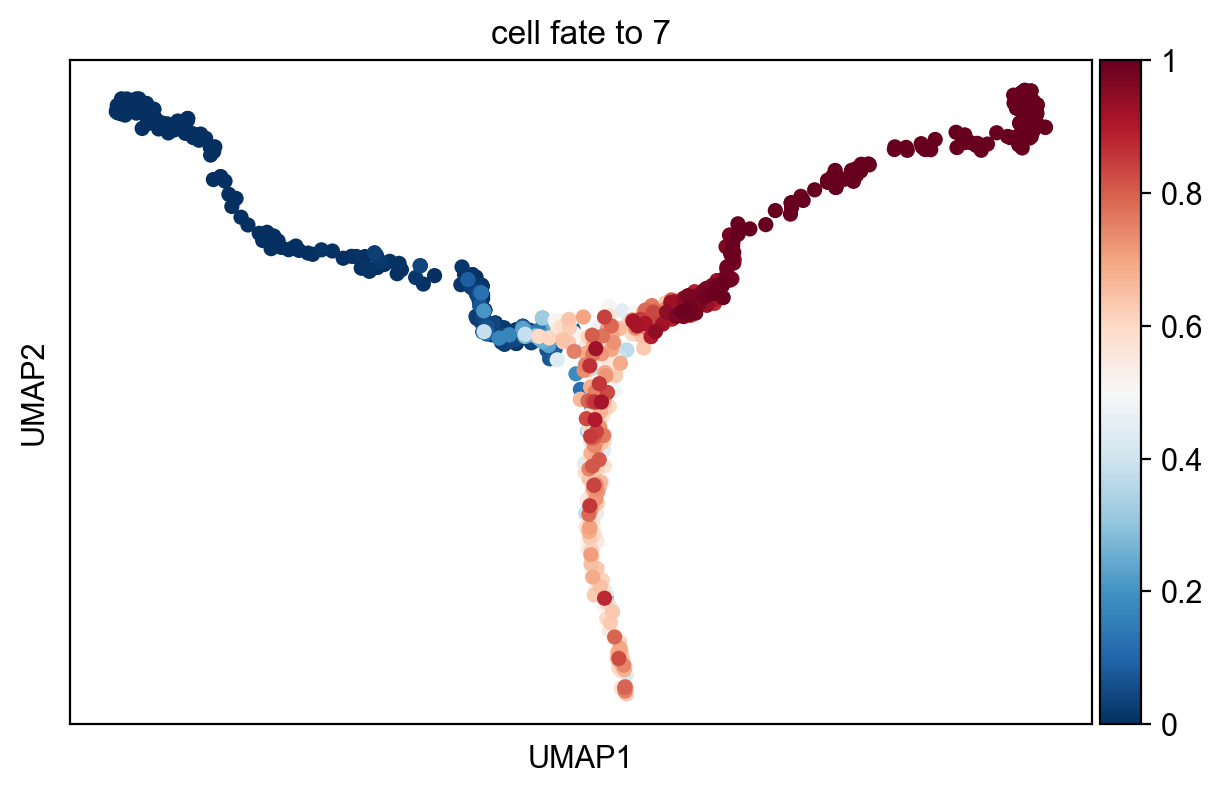

In [802]:
sc.pl.scatter(adata, color=['cell_fate_to_7'],basis="umap")

In [803]:
corr1, _ = stats.spearmanr(cellfate_velovi.iloc[:,0].values,cellfate.iloc[:,0].values)
corr2, _ = stats.spearmanr(cellfate_velovi.iloc[:,1].values,cellfate.iloc[:,1].values)
print("corr to cell fate (cluster 3): "+str(corr1))
print("corr to cell fate (cluster 7): "+str(corr2))
corr_velovi = (corr1+corr2)/2

corr to cell fate (cluster 3): 0.9662084804939183
corr to cell fate (cluster 7): 0.9662106706142435


In [728]:
g.compute_terminal_states(method="eigengap")

/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


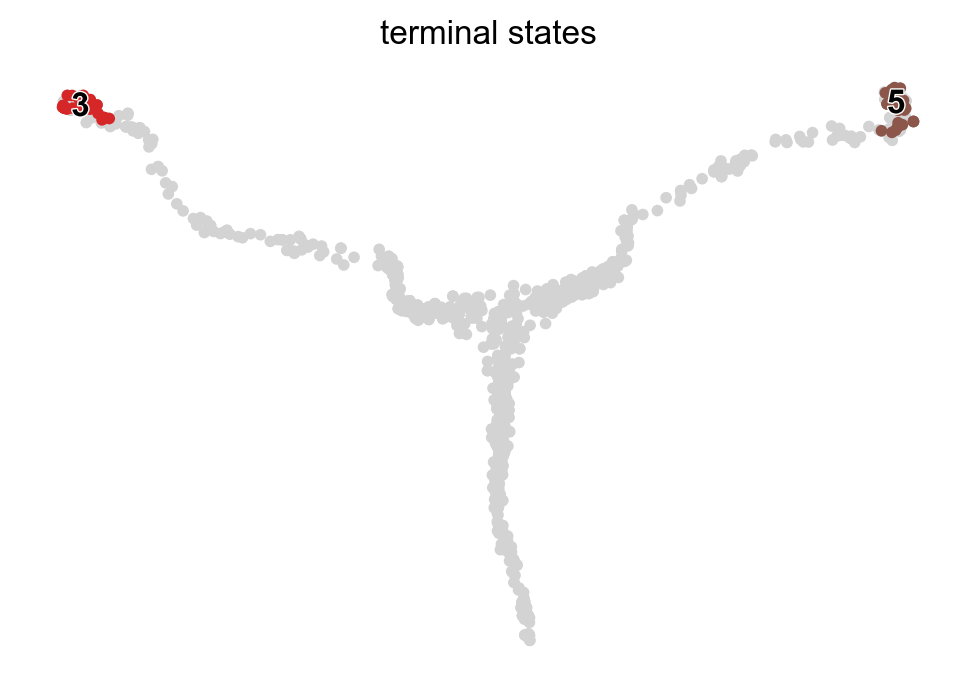

In [729]:
g.plot_terminal_states(same_plot=True)

In [804]:
(0.9662106706142435+0.9662084804939183)/2

0.9662095755540809

In [805]:
(0.9659485132113158+0.9650254764996787)/2

0.9654869948554973

In [806]:
(0.9710093022510656+0.9710093022510656)/2

0.9710093022510656

In [807]:
(0.9627516155737595+0.9623558158285215)/2

0.9625537157011406

In [811]:
d = {'Mean_Pearson_Correlation': [
              0.10919353139736739,
              0.13481842279730558,
              0.14360528289102573,
              0.13763818751375273], 
     'Model': ["VeloVI","RegVeloVI(Cor)","RegVeloVI(CellOracle)","RegVeloVI(GRNBoost2)"]}
df = pd.DataFrame(data=d)

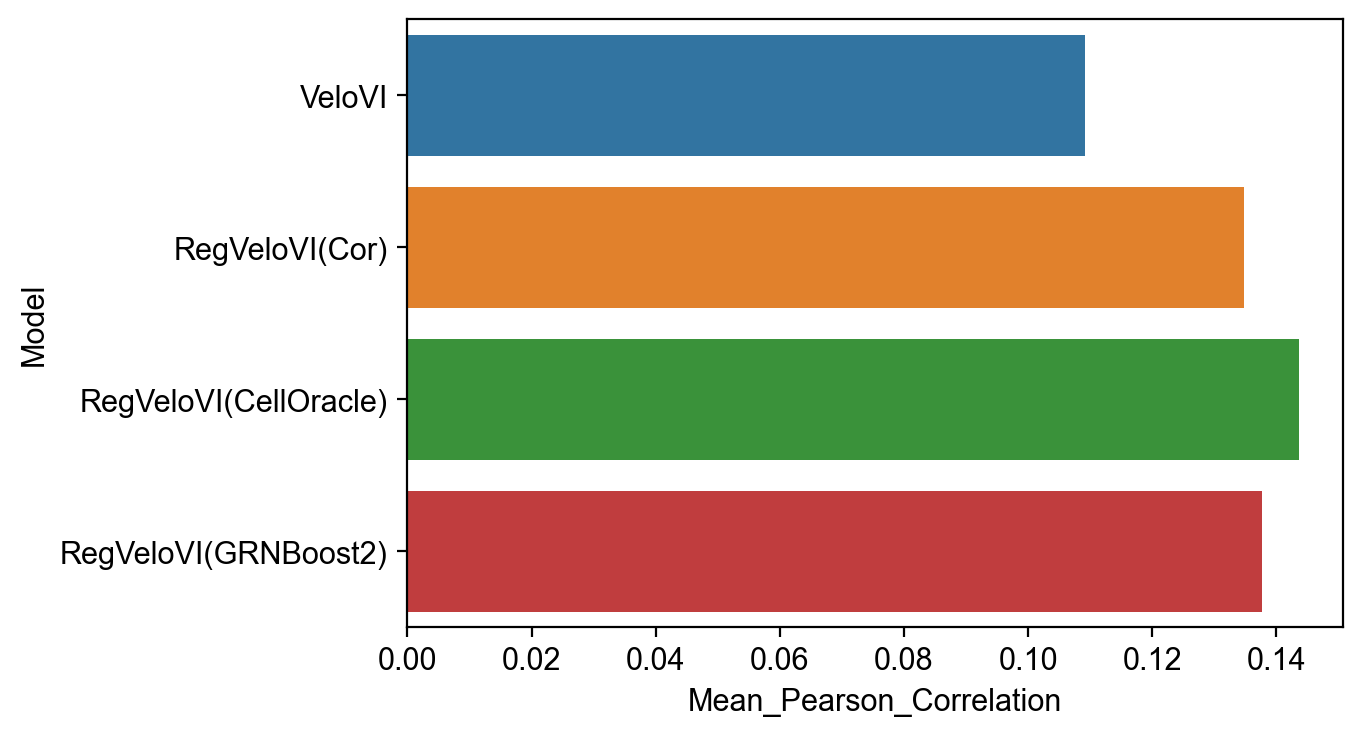

In [812]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="Mean_Pearson_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [221]:
import logging
import warnings
from typing import Iterable, List, Literal, Optional, Sequence, Tuple, Union
from anndata import AnnData
import torch.nn.functional as F

def get_pred_readout(
    self,
    adata: Optional[AnnData] = None,
    indices: Optional[Sequence[int]] = None,
    gene_list: Optional[Sequence[str]] = None,
    n_samples: int = 1,
    n_samples_overall: Optional[int] = None,
    batch_size: Optional[int] = None,
    return_mean: bool = True,
    return_numpy: Optional[bool] = None,
    velo_statistic: str = "mean",
    velo_mode: Literal["spliced", "unspliced"] = "spliced",
    clip: bool = True,
) -> Union[np.ndarray, pd.DataFrame]:
    """Returns cells by genes velocity estimates.

    Parameters
    ----------
    adata
        AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
        AnnData object used to initialize the model.
    indices
        Indices of cells in adata to use. If `None`, all cells are used.
    gene_list
        Return velocities for a subset of genes.
        This can save memory when working with large datasets and few genes are
        of interest.
    n_samples
        Number of posterior samples to use for estimation for each cell.
    n_samples_overall
        Number of overall samples to return. Setting this forces n_samples=1.
    batch_size
        Minibatch size for data loading into model. Defaults to `scvi.settings.batch_size`.
    return_mean
        Whether to return the mean of the samples.
    return_numpy
        Return a :class:`~numpy.ndarray` instead of a :class:`~pandas.DataFrame`. DataFrame includes
        gene names as columns. If either `n_samples=1` or `return_mean=True`, defaults to `False`.
        Otherwise, it defaults to `True`.
    velo_statistic
        Whether to compute expected velocity over states, or maximum a posteriori velocity over maximal
        probability state.
    velo_mode
        Compute ds/dt or du/dt.
    clip
        Clip to minus spliced value

    Returns
    -------
    If `n_samples` > 1 and `return_mean` is False, then the shape is `(samples, cells, genes)`.
    Otherwise, shape is `(cells, genes)`. In this case, return type is :class:`~pandas.DataFrame` unless `return_numpy` is True.
    """
    adata = self._validate_anndata(adata)
    if indices is None:
        indices = np.arange(adata.n_obs)
    if n_samples_overall is not None:
        indices = np.random.choice(indices, n_samples_overall)
        n_samples = 1
    scdl = self._make_data_loader(
        adata=adata, indices=indices, batch_size=batch_size
    )

    if gene_list is None:
        gene_mask = slice(None)
    else:
        all_genes = adata.var_names
        gene_mask = [True if gene in gene_list else False for gene in all_genes]

    if n_samples > 1 and return_mean is False:
        if return_numpy is False:
            warnings.warn(
                "return_numpy must be True if n_samples > 1 and return_mean is False, returning np.ndarray"
            )
        return_numpy = True
    if indices is None:
        indices = np.arange(adata.n_obs)

    pre_u_all = []
    pre_s_all = []
    for tensors in scdl:
        minibatch_samples_u = []
        minibatch_samples_s = []
        for _ in range(n_samples):
            inference_outputs, generative_outputs = self.module.forward(
                tensors=tensors,
                compute_loss=False,
            )
            pi = generative_outputs["px_pi"]
            beta = inference_outputs["beta"]
            gamma = inference_outputs["gamma"]
            tau = generative_outputs["px_tau"]
            rho = generative_outputs["px_rho"]

            ind_prob = pi[..., 0]
            #steady_prob = pi[..., 1]
            rep_prob = pi[..., 1]
            switch_time = F.softplus(self.module.switch_time_unconstr)

            ind_time = switch_time * rho
            u_0, s_0 = self.module._get_induction_unspliced_spliced(
                switch_time.reshape(1,len(switch_time))
            )
            rep_time = (self.module.t_max - switch_time) * tau
            mean_u_rep, mean_s_rep = self.module._get_repression_unspliced_spliced(
                u_0,
                s_0,
                beta,
                gamma,
                rep_time,
            )

            mean_u_ind, mean_s_ind = self.module._get_induction_unspliced_spliced(
                ind_time
            )

            # expectation
            pre_u = (
                ind_prob * mean_u_ind
                + rep_prob * mean_u_rep
            )

            pre_s = (
                ind_prob * mean_s_ind
                + rep_prob * mean_s_rep
            )

            pre_u = pre_u[..., gene_mask]
            pre_u = pre_u.detach().cpu().numpy()
            pre_s = pre_s[..., gene_mask]
            pre_s = pre_s.detach().cpu().numpy()

            minibatch_samples_u.append(pre_u)
            minibatch_samples_s.append(pre_s)
        # samples by cells by genes
        pre_u_all.append(np.stack(minibatch_samples_u, axis=0))
        pre_s_all.append(np.stack(minibatch_samples_s, axis=0))
        if return_mean:
            # mean over samples axis
            pre_u_all[-1] = np.mean(pre_u_all[-1], axis=0)
            pre_s_all[-1] = np.mean(pre_s_all[-1], axis=0)

    if n_samples > 1:
        # The -2 axis correspond to cells.
        pre_u_all = np.concatenate(pre_u_all, axis=-2)
        pre_s_all = np.concatenate(pre_s_all, axis=-2)
    else:
        pre_u_all = np.concatenate(pre_u_all, axis=0)
        pre_s_all = np.concatenate(pre_s_all, axis=0)

    if return_numpy is None or return_numpy is False:
        pre_u_all = pd.DataFrame(
            pre_u_all,
            columns=adata.var_names[self.module.target_index],
            index=adata.obs_names[indices],
        )
        pre_s_all = pd.DataFrame(
            pre_s_all,
            columns=adata.var_names[self.module.target_index],
            index=adata.obs_names[indices],
        )
        return pre_u_all, pre_s_all
    else:
        return pre_u_all, pre_s_all

In [222]:
pre_u, pre_s = get_pred_readout(reg_vae,n_samples=25, velo_statistic="mean")

In [223]:
pre_u2, pre_s2 = get_pred_readout(reg_vae2,n_samples=25, velo_statistic="mean")

In [224]:
pre_u3, pre_s3 = get_pred_readout(reg_vae3,n_samples=25, velo_statistic="mean")

In [225]:
import sklearn
rmse_s3 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s3))
rmse_u3 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u3))
rmse_s2 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s2))
rmse_u2 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u2))
rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s))
rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u))

In [226]:
(rmse_s3+rmse_u3)/2

0.12483946979045868

In [227]:
(rmse_s2+rmse_u2)/2

0.14533808827400208

In [228]:
(rmse_s+rmse_u)/2

0.08180271089076996

In [106]:
d = {'RMSE': [(rmse_s5+rmse_u5)/2, 
              (rmse_s3+rmse_u3)/2,
              (rmse_s2+rmse_u2)/2,
              (rmse_s+rmse_u)/2,
              (rmse_s4+rmse_u4)/2], 
     'Model': ["concentration: 0.3333:0.3333:0.3333", "concentration: 0.5:0.25:0.25", "concentration: 0.6:0.2:0.2", "concentration: 0.8:0.1:0.1", "concentration:1:1.001:1.001"]}
df = pd.DataFrame(data=d)

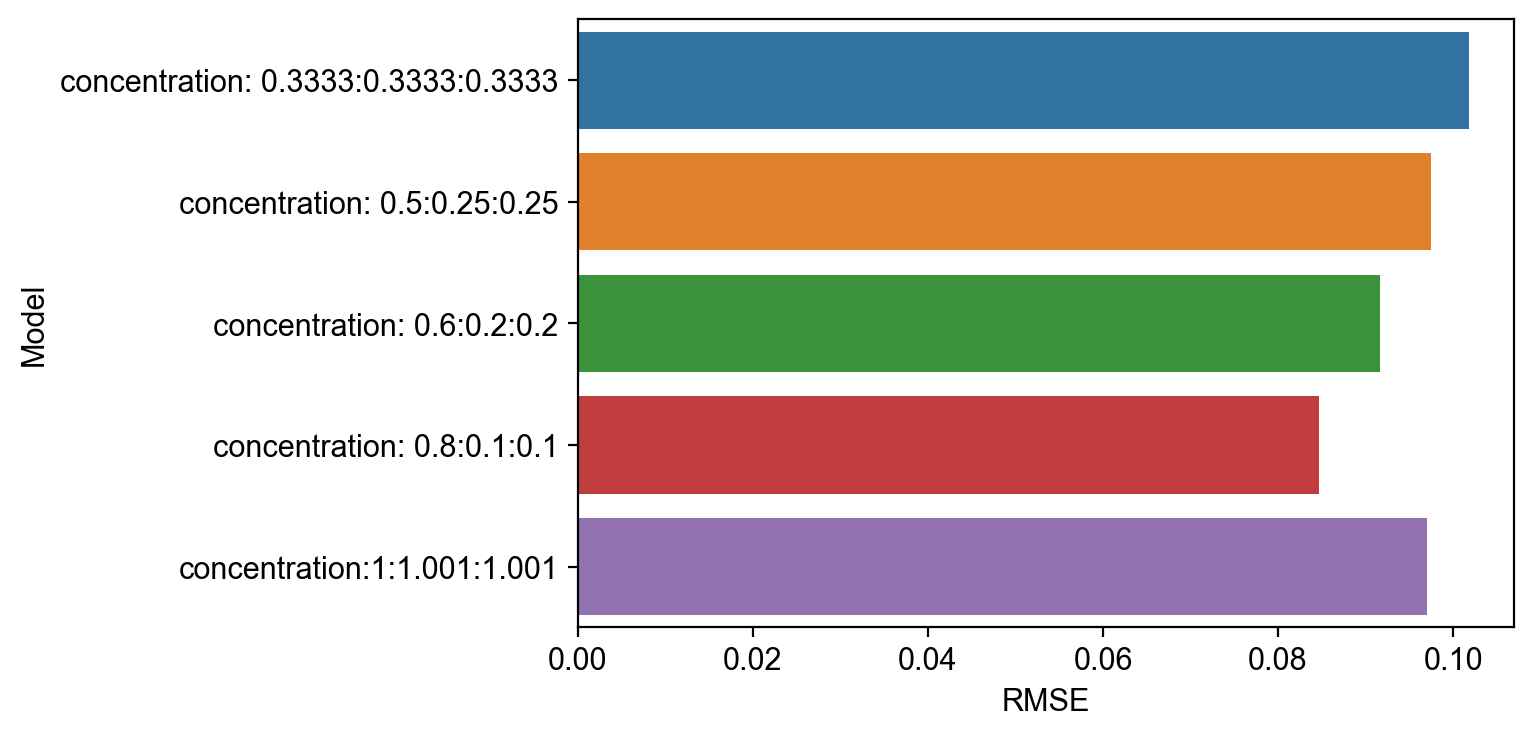

In [107]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="RMSE", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()